# GSEA with gseapy

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
BASE = '../data'

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

In [3]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [4]:
def make_ranked_df(grouped_loci):
    df = build_loci.get_sig_df(grouped_loci)
    
    # set insiginifcant loci to the center rank of the gene list
    df['logfc'] = df.where((abs(df['logfc']) <= 2) | (df['p_value'] <= 0.05))['logfc'].replace(np.nan, 0)
    
    # Right now FC ratios are light/heavy
    # light == Tcell and heavy == RAG
    # GSEA goes from low to High, so negative logFC values will come first
    # This will give genes high in RAG highest priority
    # Switching the sign with put the genes highest in Tcell mice up first
    df['logfc'] = -1 * df['logfc']
    
    # filter out the mouse and human genes
    mh_loci = build_loci.get_annotation_df(grouped_loci).query('mouse_human').index.tolist()
    df = df.query('~(id in {})'.format(mh_loci))

    
    # prep the ranking dataframe to gesapy specs.
    rank_df = df[['id', 'logfc']].rename(columns={'id': 'gene_name', 'logfc': 'rank'})
    
    return rank_df.sort_values('rank').reset_index(drop=True)


In [5]:
def make_go2Gene_map(grouped_loci, ontology='MF'):
    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(list)    
    for l in grouped_loci:
        if 'go' in l.annotations:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].append(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].append(l.cluster_id)
                
    return out

In [6]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 5 members: changed from 10 to 5 becasue small #s of proteins compared
    # to what you would find wiht genes
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 5}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    for brother in go_locus.keys():
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling]:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [7]:
def gomap_to_csv(go2gene, out_file = 'test.tsv'):

    out = ""
    for term, loci in go2gene.items():
        out += "{}\t".format(term)
        out += "{}\t".format(obodag[term].name)
        out += '\t'.join(list(map(str,loci)))
        out += '\n'
        
    with open(out_file, 'w') as fout:
        fout.write(out)

In [8]:
def run_go_gsea(rank_df, g2g_map):
    """
    A ranked df and go2gene mapping returns the result dataframe for GSEA against all go-Terms
    
    loci must be grouped such that avg_ratio and p-values are correct for 1 phenotype
    see rt_unenr_grouped_loci above for example
    """
    import gseapy as gp
        
    # save the go 2 gene map, since gseapy doesn't seem to be able to use one already in memory
    gomap_to_csv(g2g_map, 'temp.gmt')
    
    res = gp.prerank(rnk=rank_df, gene_sets='temp.gmt', outdir='tmp', min_size = 5, max_size=500, graph_num = len(g2g_map), savefigs=False)
      
    def get_go_name(term):
        return obodag[term].name
    
    res['name'] = res.index.map(get_go_name)
    
    return res.sort_values('nes', ascending=False)

In [9]:
def plot_gsea_result(row, rank):
    return gp.gsea_plot.gsea_plot(rank, row['name'], row.hit_index, row.nes, row.pval, row.fdr, row.rank_ES, phenoPos= 'Tcell', phenoNeg='RAG')

In [10]:
go2gene = make_go2Gene_map(grouped_loci)

In [11]:
len(go2gene)

613

In [12]:
tst = gp.parser.gsea_rank_metric('unenriched_genes.rnk')

In [13]:
mf_map = make_go2Gene_map(grouped_loci)
mf_map_f = filter_go2gene_map(mf_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(mf_map), len(mf_map_f)))

Unfiltered: 613	Filtered: 251


In [14]:
bp_map = make_go2Gene_map(grouped_loci, 'BP')
bp_map_f = filter_go2gene_map(bp_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(bp_map), len(bp_map_f)))

Unfiltered: 725	Filtered: 266


In [15]:
unen_rank =  make_ranked_df(unenr_grouped_loci)

In [16]:
import warnings
warnings.filterwarnings('ignore')

mf_un_res = run_go_gsea(unen_rank, mf_map_f)
bp_un_res = run_go_gsea(unen_rank, bp_map_f)

161 gene_sets have been filtered out when max_size=500 and min_size=5
90 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  1 20:52:42 2016
Start to compute esnulls................................ Thu Sep  1 20:52:42 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Thu Sep  1 20:52:55 2016
start to compute fdrs................................... Thu Sep  1 20:52:55 2016
Statistial testing finished............................. Thu Sep  1 20:52:55 2016
Start to generate gseapy reports, and produce figures... Thu Sep  1 20:52:55 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Thu Sep  1 20:52:56 2016
138 gene_sets have been filtered out when max_size=500 and min_size=5
128 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  1 20:52:57 2016
Start

In [17]:
mf_un_TC = mf_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_un_RAG = mf_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_un_TC = bp_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_un_RAG = bp_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Molecular Function - Up in Tcell

In [18]:
mf_un_TC[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016853,isomerase activity,0.799632,2.996171,0.000000,0.000668,271,90
GO:0016860,intramolecular oxidoreductase activity,0.749289,1.975892,0.003268,0.073430,93,16
GO:0016614,"oxidoreductase activity, acting on CH-OH group...",0.540728,1.700739,0.006309,0.235679,140,33
GO:0016620,"oxidoreductase activity, acting on the aldehyd...",0.487019,1.602758,0.027972,0.265626,185,37


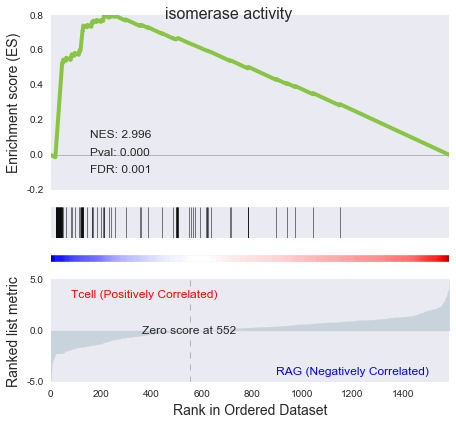

In [19]:
sns.set_style('dark')
plot_gsea_result(mf_un_TC.iloc[0], unen_rank)

### Biological Process - Up in Tcell

In [20]:
bp_un_TC[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0044724,single-organism carbohydrate catabolic process,0.610162,2.433173,0.000000,0.067875,262,138
GO:0009056,catabolic process,0.569204,2.418308,0.000000,0.075588,341,163
GO:0072524,pyridine-containing compound metabolic process,0.609703,2.417350,0.000000,0.037794,252,132
GO:0006733,oxidoreduction coenzyme metabolic process,0.609703,2.403390,0.000000,0.040108,252,132
GO:0044712,single-organism catabolic process,0.599509,2.398892,0.000000,0.026739,299,147
GO:0046939,nucleotide phosphorylation,0.609703,2.390508,0.000000,0.020054,247,132
GO:0046496,nicotinamide nucleotide metabolic process,0.609703,2.363421,0.000000,0.018203,251,132
GO:0006753,nucleoside phosphate metabolic process,0.538258,2.285595,0.000000,0.024373,393,158
GO:0009132,nucleoside diphosphate metabolic process,0.609703,2.281723,0.000000,0.024682,247,132


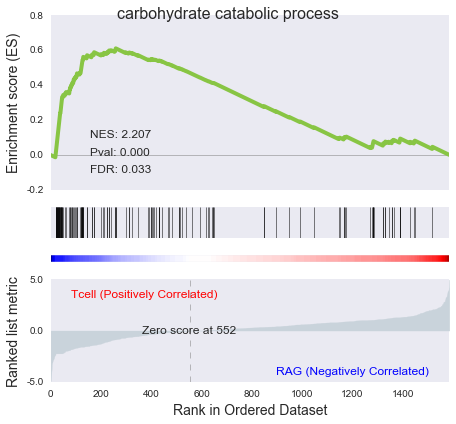

In [21]:
plot_gsea_result(bp_un_TC.loc['GO:0016052'], unen_rank)

### Molecular Function - Up in RAG

In [22]:
mf_un_RAG[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0034062,RNA polymerase activity,-0.547794,-2.454964,0.000000,0.000000,142,82
GO:0016779,nucleotidyltransferase activity,-0.488109,-2.393991,0.000000,0.000000,255,119
GO:0003677,DNA binding,-0.462263,-2.057587,0.000000,0.000000,147,85
GO:0016781,"phosphotransferase activity, paired acceptors",-0.453596,-2.043281,0.000000,0.000000,199,73
GO:0022892,substrate-specific transporter activity,-0.710105,-1.921836,0.000000,0.000355,82,16
GO:0022891,substrate-specific transmembrane transporter a...,-0.710105,-1.912487,0.000000,0.000592,80,16
GO:0022804,active transmembrane transporter activity,-0.648388,-1.906959,0.000000,0.000634,138,34
GO:0004478,methionine adenosyltransferase activity,-0.611631,-1.893819,0.001527,0.000777,83,31
GO:0016765,"transferase activity, transferring alkyl or ar...",-0.611631,-1.883810,0.000000,0.000690,84,31


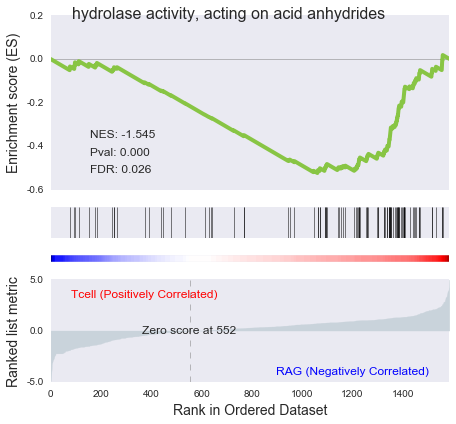

In [23]:
plot_gsea_result(mf_un_RAG.loc['GO:0016817'], unen_rank)

### Biological Process - Up in RAG

In [24]:
bp_un_RAG[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0032774,RNA biosynthetic process,-0.547794,-2.504154,0.000000,1.000000e+09,144,82
GO:0016070,RNA metabolic process,-0.496608,-2.477919,0.000000,0.000000e+00,307,100
GO:0097659,nucleic acid-templated transcription,-0.547794,-2.388499,0.000000,0.000000e+00,142,82
GO:0090304,nucleic acid metabolic process,-0.497782,-2.385036,0.000000,0.000000e+00,318,101
GO:0019438,aromatic compound biosynthetic process,-0.473302,-2.224887,0.000000,0.000000e+00,272,103
GO:1901362,organic cyclic compound biosynthetic process,-0.467044,-2.140016,0.000000,0.000000e+00,279,105
GO:0034654,nucleobase-containing compound biosynthetic pr...,-0.476661,-2.125903,0.000000,0.000000e+00,242,96
GO:0018130,heterocycle biosynthetic process,-0.467044,-2.124221,0.000000,0.000000e+00,278,105
GO:0034637,cellular carbohydrate biosynthetic process,-0.602021,-2.023721,0.000000,0.000000e+00,52,28


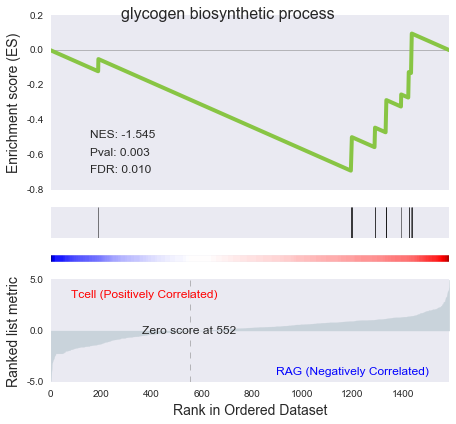

In [25]:
plot_gsea_result(bp_un_RAG.loc['GO:0005978'], unen_rank)

## GSEA on BioGlyCMK Enriched Samples

In [26]:
enr_rank =  make_ranked_df(enr_grouped_loci)

In [27]:
# [l for l in enr_grouped_loci if l.cluster_id in enr_rank['gene_name'].tolist()]
enr_mf_map = make_go2Gene_map(enr_grouped_loci)
enr_mf_map_f = filter_go2gene_map(enr_mf_map)
print('MF Unfiltered: {}\tFiltered: {}'.format(len(enr_mf_map), len(enr_mf_map_f)))

enr_bp_map = make_go2Gene_map(enr_grouped_loci, 'BP')
enr_bp_map_f = filter_go2gene_map(enr_bp_map)
print('BP Unfiltered: {}\tFiltered: {}'.format(len(enr_bp_map), len(enr_bp_map_f)))

MF Unfiltered: 512	Filtered: 211
BP Unfiltered: 618	Filtered: 209


In [28]:
mf_enr_res = run_go_gsea(enr_rank, enr_mf_map_f)
bp_enr_res = run_go_gsea(enr_rank, enr_bp_map_f)

140 gene_sets have been filtered out when max_size=500 and min_size=5
71 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  1 20:53:19 2016
Start to compute esnulls................................ Thu Sep  1 20:53:19 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Thu Sep  1 20:53:26 2016
start to compute fdrs................................... Thu Sep  1 20:53:26 2016
Statistial testing finished............................. Thu Sep  1 20:53:26 2016
Start to generate gseapy reports, and produce figures... Thu Sep  1 20:53:26 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Thu Sep  1 20:53:26 2016
116 gene_sets have been filtered out when max_size=500 and min_size=5
93 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  1 20:53:28 2016
Start 

In [29]:
mf_enr_TC = mf_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_enr_RAG = mf_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_enr_TC = bp_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_enr_RAG = bp_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Up in T-Cell: Molecular Function

In [30]:
mf_enr_TC[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016741,"transferase activity, transferring one-carbon ...",0.897260,2.160746,0.000000,0.140301,30,9
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",0.717315,2.048165,0.000000,0.117687,56,24
GO:0004175,endopeptidase activity,0.812785,1.962479,0.000000,0.114149,36,11
GO:0008233,peptidase activity,0.686780,1.880569,0.000000,0.129686,103,21
GO:0016787,hydrolase activity,0.443384,1.819360,0.000000,0.131071,436,128
GO:0005515,protein binding,0.620810,1.703056,0.016484,0.179069,91,20
GO:0016798,"hydrolase activity, acting on glycosyl bonds",0.583454,1.612326,0.000000,0.218496,57,17
GO:0003676,nucleic acid binding,0.533491,1.555999,0.044776,0.241258,116,27
GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl com...",0.580609,1.522104,0.048000,0.250450,54,16


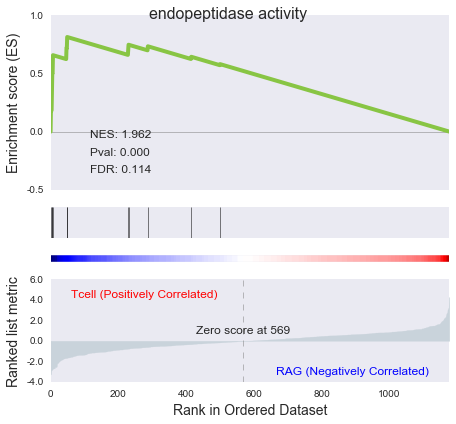

In [31]:
plot_gsea_result(mf_enr_TC.loc['GO:0004175'], enr_rank)

### Up in T-Cell: Biological Process

In [32]:
bp_enr_TC[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006508,proteolysis,0.676541,1.929564,0.000000,0.578141,77,21
GO:0044248,cellular catabolic process,0.735177,1.875938,0.009804,0.354475,45,12
GO:0034654,nucleobase-containing compound biosynthetic pr...,0.658534,1.849152,0.013575,0.265385,72,21
GO:1901293,nucleoside phosphate biosynthetic process,0.691073,1.814779,0.015152,0.228107,43,14
GO:0009165,nucleotide biosynthetic process,0.691073,1.803348,0.000000,0.191529,41,14
GO:0090407,organophosphate biosynthetic process,0.674991,1.778808,0.004695,0.173604,60,15
GO:0044282,small molecule catabolic process,0.709572,1.720031,0.016129,0.191253,31,11
GO:0019438,aromatic compound biosynthetic process,0.563896,1.670164,0.041401,0.208325,93,31
GO:0044271,cellular nitrogen compound biosynthetic process,0.498229,1.662084,0.017730,0.192534,134,39


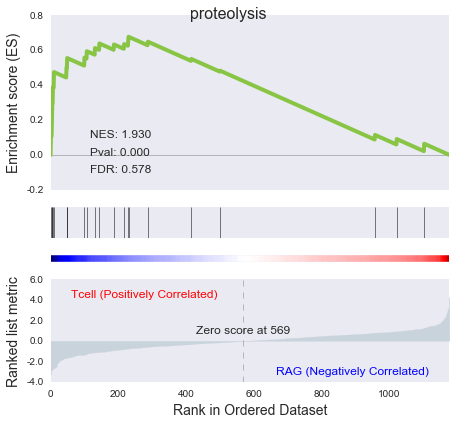

In [33]:
plot_gsea_result(bp_enr_TC.loc['GO:0006508'], enr_rank)

### Up in RAG: Molecular Function

In [34]:
mf_enr_RAG[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016781,"phosphotransferase activity, paired acceptors",-0.731611,-2.448464,0.000000,0.000000,175,61
GO:0016301,kinase activity,-0.595516,-2.320167,0.000000,0.000000,223,72
GO:0030554,adenyl nucleotide binding,-0.466162,-2.063898,0.000000,0.000361,440,153
GO:0032559,adenyl ribonucleotide binding,-0.475374,-2.045824,0.000000,0.000271,431,150
GO:0051540,metal cluster binding,-0.550312,-1.968107,0.002028,0.001083,89,38
GO:0016887,ATPase activity,-0.532082,-1.868443,0.000000,0.002527,52,32
GO:0022804,active transmembrane transporter activity,-0.618889,-1.694726,0.004329,0.013460,42,14
GO:0016820,"hydrolase activity, acting on acid anhydrides,...",-0.618889,-1.690753,0.016393,0.012319,41,14
GO:0022857,transmembrane transporter activity,-0.618889,-1.670799,0.011468,0.013477,49,14


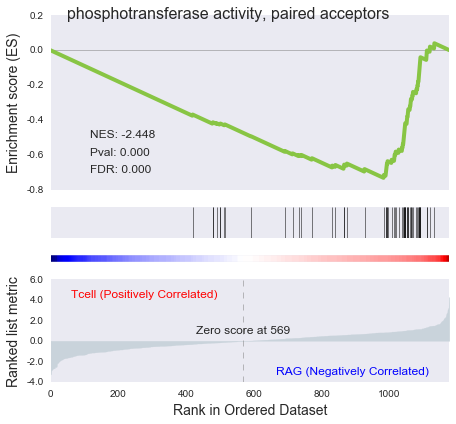

In [35]:
plot_gsea_result(mf_enr_res.loc['GO:0016781'], enr_rank)

### Up in RAG: Biological Process

In [36]:
bp_enr_RAG[['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006457,protein folding,-0.593953,-1.825775,0.009174,0.007380,71,20
GO:0006812,cation transport,-0.676945,-1.811524,0.001667,0.004825,71,16
GO:0015672,monovalent inorganic cation transport,-0.676945,-1.805476,0.003373,0.003406,65,16
GO:0006811,ion transport,-0.676945,-1.797620,0.000000,0.002980,73,16
GO:0042026,protein refolding,-0.631852,-1.676001,0.004202,0.009991,35,14
GO:0016051,carbohydrate biosynthetic process,-0.491980,-1.662791,0.000000,0.009272,104,45
GO:0034637,cellular carbohydrate biosynthetic process,-0.878469,-1.602026,0.000000,0.016219,34,8
GO:0016310,phosphorylation,-0.385314,-1.601099,0.001355,0.014263,317,138
GO:0032787,monocarboxylic acid metabolic process,-0.356095,-1.595498,0.001761,0.013814,341,157


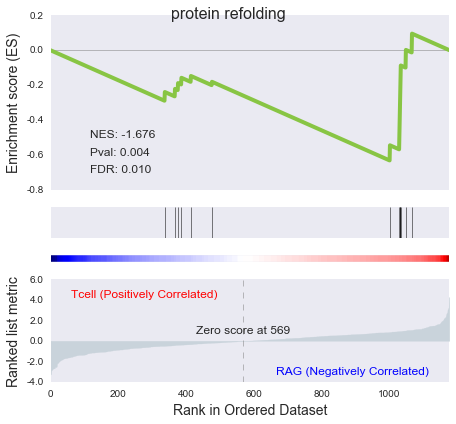

In [37]:
plot_gsea_result(bp_enr_res.loc['GO:0042026'], enr_rank)